# Finite volume methods for the Darcy equation

In this tutorial we present how to solve a Darcy equation with [PorePy](https://github.com/pmgbergen/porepy) by using two finite volume methods: two-point flux approximation (TPFA) and multi-point flux approximation (MPFA).

## Exercise 2

We consider the primal formulation of the Darcy problem: the only unknown is the pressure $p$.
We want to solve the problem on different families of grids.

Let $\Omega$ be the domain of interest with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k=I$ the matrix permeability and $f = 1$ the source term, we want to solve the following problem: find $p$ such that
$$
\nabla \cdot (- \nabla p) = f
\quad \text{in } \Omega
$$
with boundary conditions:
$$
\left\{
\begin{array}{ll}
p = 0 & \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega\\
-\nabla p \cdot \nu = 0  & \text{ on } \partial_{top} \Omega \cup \partial_{bottom} \Omega
\end{array}
\right.
$$
Let $\Omega_0 = [0, 1]^2$ and define the shear matrix $S$ as
$$
S =
\begin{bmatrix}
1 & \tan\theta\\
0 & 1
\end{bmatrix}
$$
with $\theta \in [0, \pi/2)$ the shear angle. We define $\Omega = S \circ \Omega_0$.

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules.

In [1]:
import numpy as np

import porepy as pp
import pygeon as pg

We create now the grid and then apply the shear matrix $S$ before calling the `compute_geometry`. Since, on a Cartesian grid and for $\theta = 0$, the pressure computed with TPFA is equal with the pressure computed with MPFA, we consider a Cartesian grid and study the discrepancy between the two solutions by increasing $\theta$.

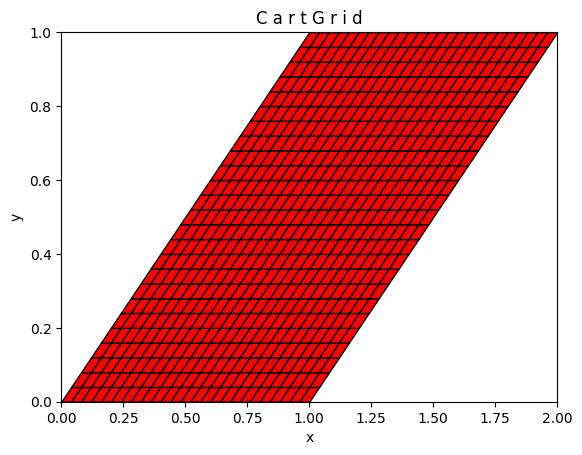

In [2]:
dim = 2

# creation of a Cartesian grid
N = 25
sd = pp.CartGrid([N] * dim, [1] * dim)
pg.convert_from_pp(sd)

# define the shear matrix
theta = np.pi / 4
S = np.array([[1, np.tan(theta), 0], [0, 1, 0], [0, 0, 1]])

# distort the matrix
sd.nodes = S @ sd.nodes

sd.compute_geometry()

# represent the grid
pp.plot_grid(sd, plot_2d=True)

With the following code we set the data, in particular the permeability tensor and the scalar source.

In [3]:
key = "flow"

# Permeability
perm = pp.SecondOrderTensor(np.ones(sd.num_cells))

# Boundary conditions
b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]

# With the following steps we identify the portions of the boundary
# to impose the boundary conditions
bottom = np.isclose(sd.face_centers[1, b_faces], 0)
top = np.isclose(sd.face_centers[1, b_faces], 1)
bottom_top = np.logical_or(bottom, top)

# Set the labels for the boundary conditions
labels = np.array(["dir"] * b_faces.size)
labels[bottom_top] = "neu"

bc = pp.BoundaryCondition(sd, b_faces, labels)
bc_val = np.zeros(sd.num_faces)

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "bc": bc, "bc_values": bc_val}

data = pp.initialize_default_data(sd, {}, key, parameters)

Once the data are assigned to the grid, we need to construct the discrete problem. In particular, the linear system associated with the equation is given as
$$
A p = b
$$<br>
The right-hand side term $b$ includes the part associated with the scalar source term and with the boundary conditions, we construct first the former.

In [4]:
# construct the rhs from the discretization of the scalar source term
p0 = pg.PwConstants(key)
# NOTE: we do not use the mass matrix here, since PorePy uses a different convention for the scalar variables
scalar_source = p0.interpolate(sd, lambda _: 1)

Second, we construct the matrix $A$ from the TPFA approximation and the part of the right-hand side associated to the boundary conditions. We can compute the pressure $p$ by solving the linear system.

In [5]:
# construct the lhr and rhs from the discretization of the diffusion operator
tpfa = pp.Tpfa(key)
tpfa.discretize(sd, data)
A_tpfa, b_tpfa = tpfa.assemble_matrix_rhs(sd, data)

# solve the problem
ls = pg.LinearSystem(A_tpfa, b_tpfa + scalar_source)
cell_p_tpfa = ls.solve()

As a post-process, we can construct the Darcy flux on each face of the grid by using the flux matrix applied to the computed pressure. 

In [6]:
# extract the discretization matrices build from TPFA
mat_discr = data[pp.DISCRETIZATION_MATRICES][key]

# reconstruct the flux as post-process
q_tpfa = mat_discr["flux"] @ cell_p_tpfa + mat_discr["bound_flux"] @ bc_val

We perform the same steps with the MPFA scheme: to construct the matrix $A$, and associated right-hand side, then compute the pressure $p$ and as a post-process the flux.

In [7]:
# construct the lhr and rhs from the discretization of the diffusion operator
mpfa = pp.Mpfa(key)
mpfa.discretize(sd, data)
A_mpfa, b_mpfa = mpfa.assemble_matrix_rhs(sd, data)

# solve the problem
ls = pg.LinearSystem(A_mpfa, b_mpfa + scalar_source)
cell_p_mpfa = ls.solve()

# now data contains the discretization matrices build from MPFA
mat_discr = data[pp.DISCRETIZATION_MATRICES][key]

q_mpfa = mat_discr["flux"] @ cell_p_mpfa + mat_discr["bound_flux"] @ bc_val

We compute now the discrepancy between the pressure computed with the TPFA and MPFA.

In [8]:
# compute the difference between the two solutions
cell_diff = cell_p_tpfa - cell_p_mpfa

mass = p0.assemble_mass_matrix(sd)

norm_mpfa = np.sqrt(cell_p_mpfa.T @ mass @ cell_p_mpfa)
norm_diff = np.sqrt(cell_diff.T @ mass @ cell_diff)

print("difference", norm_diff, norm_diff / norm_mpfa)

difference 25.368071462534182 0.7834670888043769


Let us now reconstruct the $P_0$-vector representation of the flux for visualization purposes.

In [9]:
# to export the flux we consider the virtual version of the rt0 to work on any cell type
vrt0 = pg.VRT0(key)

# compute an operator for evaluating the flux in the cell centers
proj = vrt0.eval_at_cell_centers(sd)

# construct the P0 flux reconstruction, no reshape is needed
cell_q_tpfa = proj @ q_tpfa
cell_q_mpfa = proj @ q_mpfa

We export the solutions to be visualized by [ParaView](https://www.paraview.org/).

In [10]:
save = pp.Exporter(sd, "sol", folder_name="ex2")
exp_p = [("cell_p_tpfa", cell_p_tpfa), ("cell_p_mpfa", cell_p_mpfa)]
exp_q = [("cell_q_tpfa", cell_q_tpfa), ("cell_q_mpfa", cell_q_mpfa)]
save.write_vtu(exp_p + exp_q)

In [11]:
# Consistency check
assert np.isclose(np.linalg.norm(norm_diff), 25.368071462534182)